## Data Loading

In [1]:
import pandas as pd

try:
    df = pd.read_csv('C:/Users/A Esther Graceia/climate_anomalies_dataset.csv')
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Error: 'climate_anomalies_dataset.csv' not found.")
    df = None 


Year  Country  CO2_Emissions_MT  Temperature_Anomaly_C  Precipitation_mm  \
0  1980      USA          32331.91                  -1.40           1187.57   
1  1980    India           7837.36                  -1.09           2351.67   
2  1980    China           5260.00                   0.19            574.49   
3  1980   Brazil          12400.38                   0.91           1903.11   
4  1980  Germany          35364.92                   0.18           1623.02   

   Extreme_Weather_Events  Anomaly_Label  
0                       3              0  
1                       8              1  
2                       3              0  
3                      10              1  
4                       4              0

(450, 7)


## Data Exploration

Data shape: (450, 7)

Data types:
 Year                        int64
Country                    object
CO2_Emissions_MT          float64
Temperature_Anomaly_C     float64
Precipitation_mm          float64
Extreme_Weather_Events      int64
Anomaly_Label               int64
dtype: object

Missing values:
 Year                      0
Country                   0
CO2_Emissions_MT          0
Temperature_Anomaly_C     0
Precipitation_mm          0
Extreme_Weather_Events    0
Anomaly_Label             0
dtype: int64


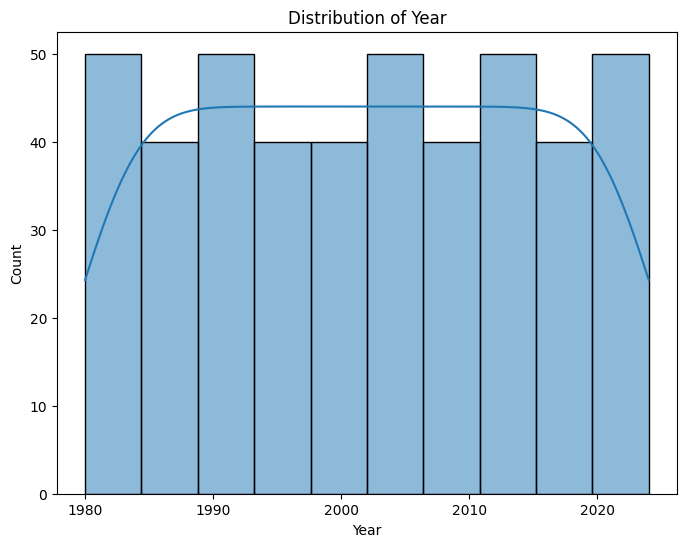

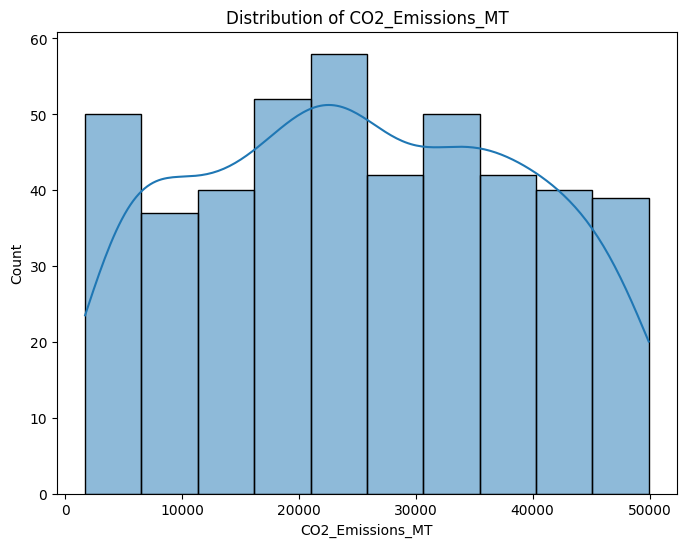

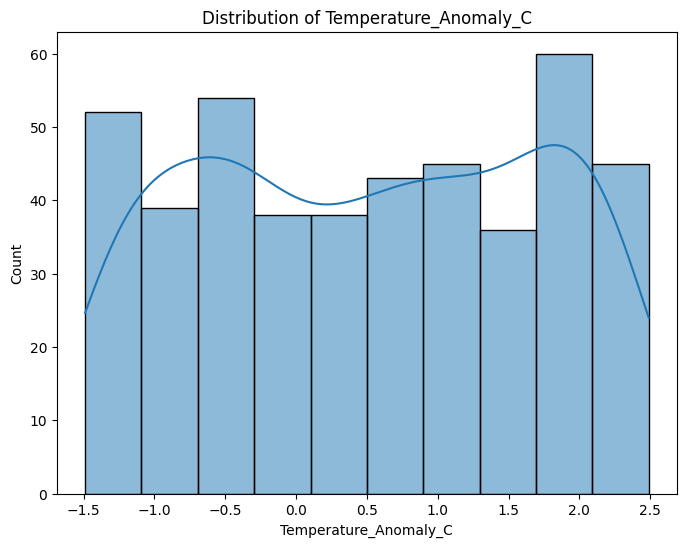

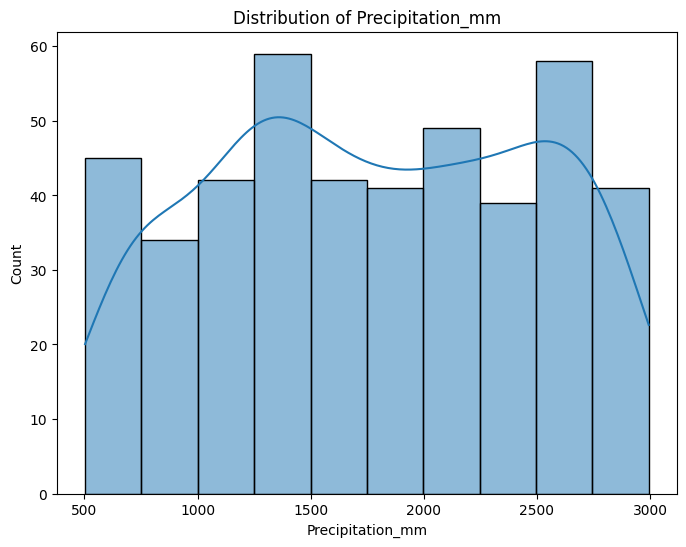

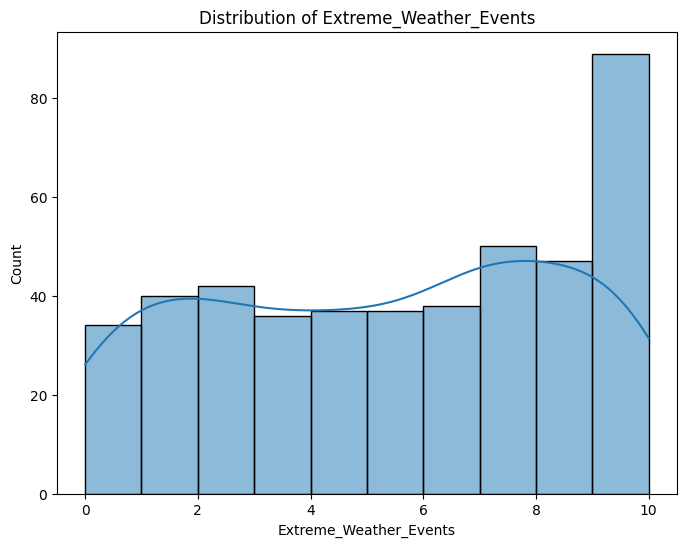

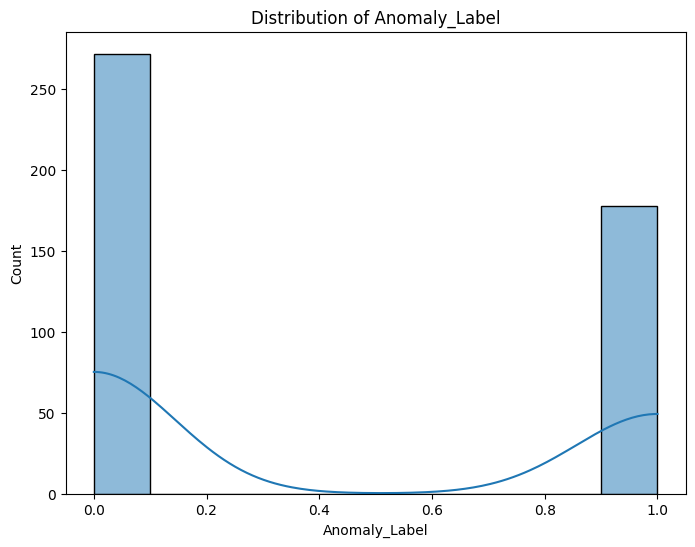

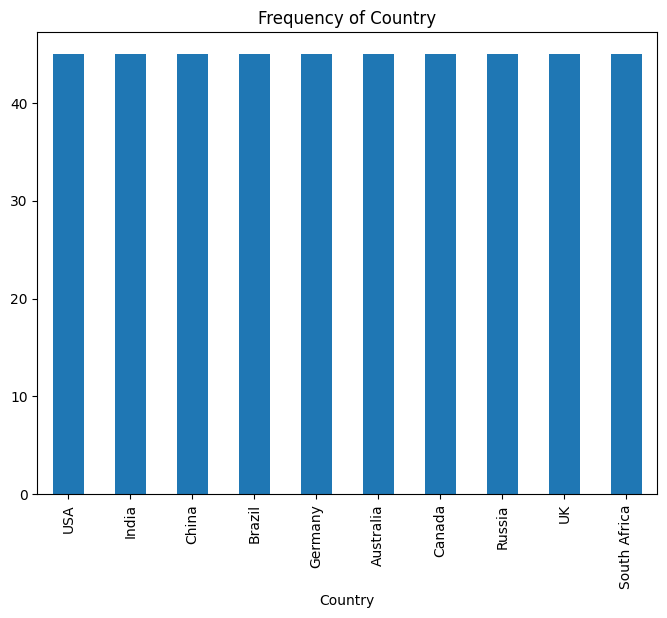


Target Variable: Anomaly_Label
Target Variable Data Type: int64
Unique Values in Target Variable: [0 1]

Summary Statistics:
               Year  CO2_Emissions_MT  Temperature_Anomaly_C  Precipitation_mm  \
count   450.000000        450.000000             450.000000        450.000000   
mean   2002.000000      25367.298689               0.507644       1775.358578   
std      13.001627      13643.737454               1.186795        708.428780   
min    1980.000000       1693.270000              -1.490000        502.880000   
25%    1991.000000      14087.185000              -0.537500       1208.337500   
50%    2002.000000      25197.005000               0.545000       1755.110000   
75%    2013.000000      36892.237500               1.575000       2397.692500   
max    2024.000000      49930.750000               2.490000       2993.840000   

       Extreme_Weather_Events  Anomaly_Label  
count              450.000000     450.000000  
mean                 5.248889       0.395556  
st

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Data shape:", df.shape)
print("\nData types:\n", df.dtypes)

print("\nMissing values:\n", df.isnull().sum())

numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {col}')
    plt.show()

print("\nTarget Variable: Anomaly_Label")
print("Target Variable Data Type:", df['Anomaly_Label'].dtype)
print("Unique Values in Target Variable:", df['Anomaly_Label'].unique())
print("\nSummary Statistics:\n", df.describe())

## Data Cleaning

In [3]:
import pandas as pd
import numpy as np

df = pd.get_dummies(df, columns=['Country'], prefix='Country')

for col in df.columns:
    if df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(method='ffill')

numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower_bound, upper_bound)
display(df.head())

Year  CO2_Emissions_MT  Temperature_Anomaly_C  Precipitation_mm  \
0  1980          32331.91                  -1.40           1187.57   
1  1980           7837.36                  -1.09           2351.67   
2  1980           5260.00                   0.19            574.49   
3  1980          12400.38                   0.91           1903.11   
4  1980          35364.92                   0.18           1623.02   

   Extreme_Weather_Events  Anomaly_Label  Country_Australia  Country_Brazil  \
0                       3              0              False           False   
1                       8              1              False           False   
2                       3              0              False           False   
3                      10              1              False            True   
4                       4              0              False           False   

   Country_Canada  Country_China  Country_Germany  Country_India  \
0           False          False            False          False   
1           False          False            False           True   
2           False           True            False          False   
3           False          False            False          False   
4           False          False             True          False   

   Country_Russia  Country_South Africa  Country_UK  Country_USA  
0           False                 False       False         True  
1           False                 False       False        False  
2           False                 False       False        False  
3           False                 False       False        False  
4           False                 False       False        False

## Feature Engineering

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

for col in ['CO2_Emissions_MT', 'Temperature_Anomaly_C', 'Precipitation_mm', 'Extreme_Weather_Events']:
    for lag in range(1, 4):  
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

for col in ['CO2_Emissions_MT', 'Temperature_Anomaly_C', 'Precipitation_mm', 'Extreme_Weather_Events']:
    for window in [3, 5]: 
        df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
        df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()

df['CO2_Temp_Interaction'] = df['CO2_Emissions_MT'] * df['Temperature_Anomaly_C']

scaler = MinMaxScaler()
numerical_cols = ['CO2_Emissions_MT', 'Temperature_Anomaly_C', 'Precipitation_mm', 'Extreme_Weather_Events']
scaled_data = scaler.fit_transform(df[numerical_cols])
df[numerical_cols] = scaled_data

df = df.dropna() 
correlations = df.corr()['Anomaly_Label'].abs().sort_values(ascending=False)
N = 15 
selected_features = correlations[1:N+1].index.tolist() 
df = df[selected_features + ['Anomaly_Label']]


display(df.head())

Extreme_Weather_Events  Extreme_Weather_Events_rolling_mean_3  \
4                     0.4                               5.666667   
5                     0.6                               6.666667   
6                     0.5                               5.000000   
7                     0.5                               5.333333   
8                     0.8                               6.000000   

   Temperature_Anomaly_C  Extreme_Weather_Events_rolling_mean_5  \
4               0.419598                                    5.6   
5               0.005025                                    6.2   
6               0.153266                                    5.6   
7               0.379397                                    6.0   
8               0.809045                                    5.6   

   CO2_Temp_Interaction  Temperature_Anomaly_C_rolling_std_5  \
4             6365.6856                             0.968489   
5           -59773.2723                             0.989687   
6           -15551.6064                             0.949068   
7              120.1660                             0.933900   
8            52907.8634                             1.217140   

   Temperature_Anomaly_C_rolling_mean_3  Temperature_Anomaly_C_rolling_mean_5  \
4                              0.426667                                -0.242   
5                             -0.126667                                -0.256   
6                             -0.723333                                -0.214   
7                             -0.776667                                -0.248   
8                              0.290000                                -0.084   

   Temperature_Anomaly_C_rolling_std_3  Extreme_Weather_Events_rolling_std_5  \
4                             0.418609                              3.209361   
5                             1.219276                              2.863564   
6                             0.836082                              2.701851   
7                             0.750355                              2.345208   
8                             1.325783                              1.516575   

   CO2_Emissions_MT_lag_1  Precipitation_mm_rolling_std_5  \
4                12400.38                      680.669245   
5                35364.92                      767.875303   
6                40662.09                      894.073709   
7                17672.28                      623.477945   
8                 6008.30                      624.383601   

   Temperature_Anomaly_C_lag_3  CO2_Emissions_MT_rolling_std_3  \
4                        -1.09                    15730.338692   
5                         0.19                    15023.062047   
6                         0.91                    12038.970637   
7                         0.18                    17632.663604   
8                        -1.47                    12292.406281   

   Extreme_Weather_Events_lag_2  Anomaly_Label  
4                           3.0              0  
5                          10.0              0  
6                           4.0              0  
7                           6.0              0  
8                           5.0              1

## Data Splitting

In [5]:
from sklearn.model_selection import train_test_split
X = df.drop('Anomaly_Label', axis=1)
y = df['Anomaly_Label']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


## Model Training

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Model Optimization

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_grid = {
    'n_estimators': randint(50, 200),         
    'max_depth': randint(10, 50),          
    'min_samples_split': randint(2, 20),     
    'min_samples_leaf': randint(1, 10),      
    'max_features': uniform(0.1, 0.9),  
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1',  
    cv=5,  
    verbose=1,
    random_state=42,
    n_jobs=-1  
)

random_search.fit(X_val, y_val)
print("Best hyperparameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'max_depth': 48, 'max_features': np.float64(0.8168886881742096), 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171}
Best score: 1.0


## Model Evaluation

In [8]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

auc_roc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print(f"AUC-ROC Score: {auc_roc}")

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        54
           1       0.92      1.00      0.96        36

    accuracy                           0.97        90
   macro avg       0.96      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90

AUC-ROC Score: 1.0


## Model Evaluation

In [9]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Anomaly', 'Anomaly'],
    mode='classification',
    discretize_continuous=True
)

instances_to_explain = [X_test.iloc[i] for i in [0, 1, 5, 10]]  

explanations = []
for instance in instances_to_explain:
  explanation = explainer.explain_instance(
      instance.values,
      best_rf_model.predict_proba,
      num_features=5,
      num_samples=1000 
  )
  explanations.append(explanation)

for i, explanation in enumerate(explanations):
    print(f"Explanation for instance {i}:")
    explanation.show_in_notebook(show_table=True)
    print("\n")

C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Explanation for instance 0:


C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(




Explanation for instance 1:




Explanation for instance 2:




Explanation for instance 3:


## Model Evaluation

C:\Users\A Esther Graceia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


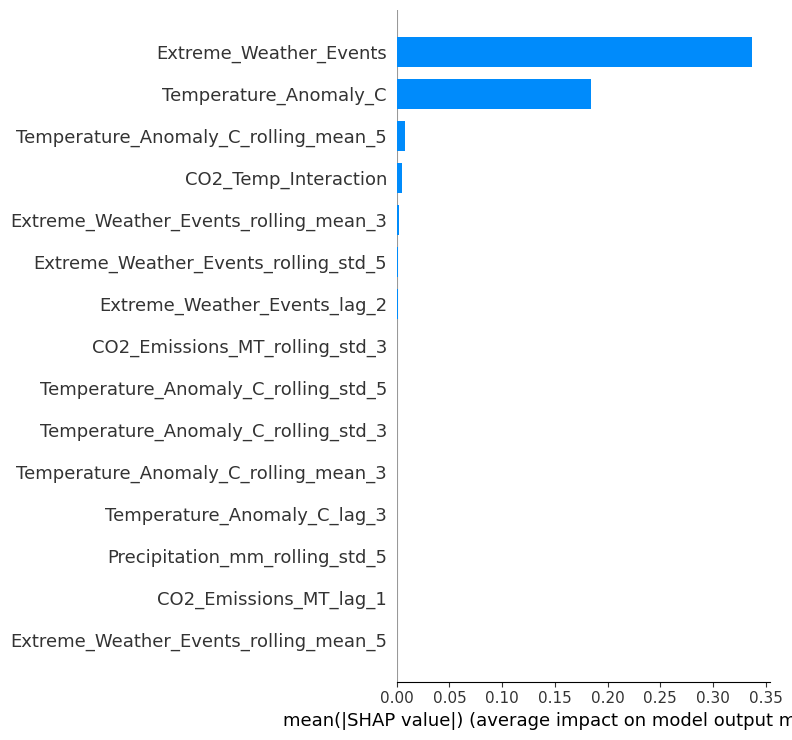

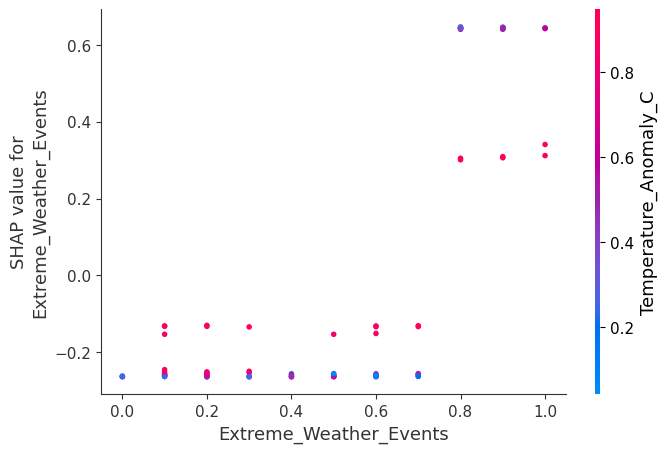

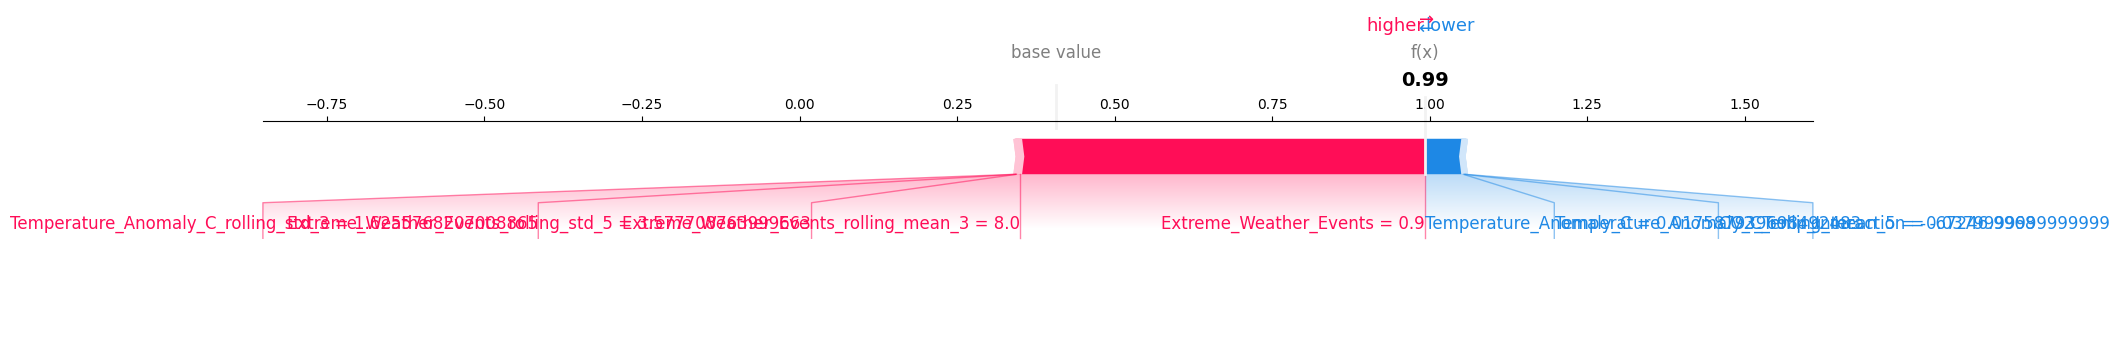

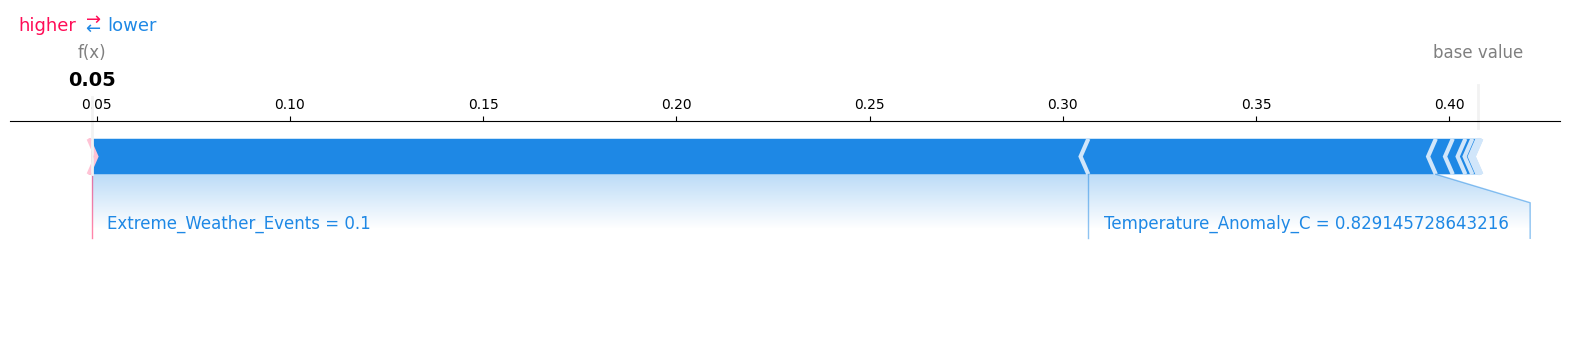

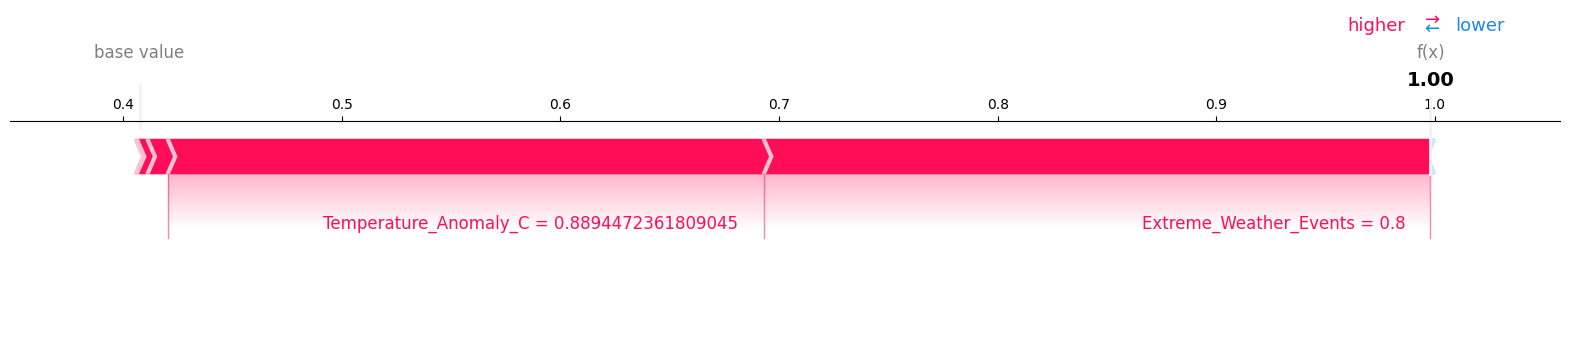

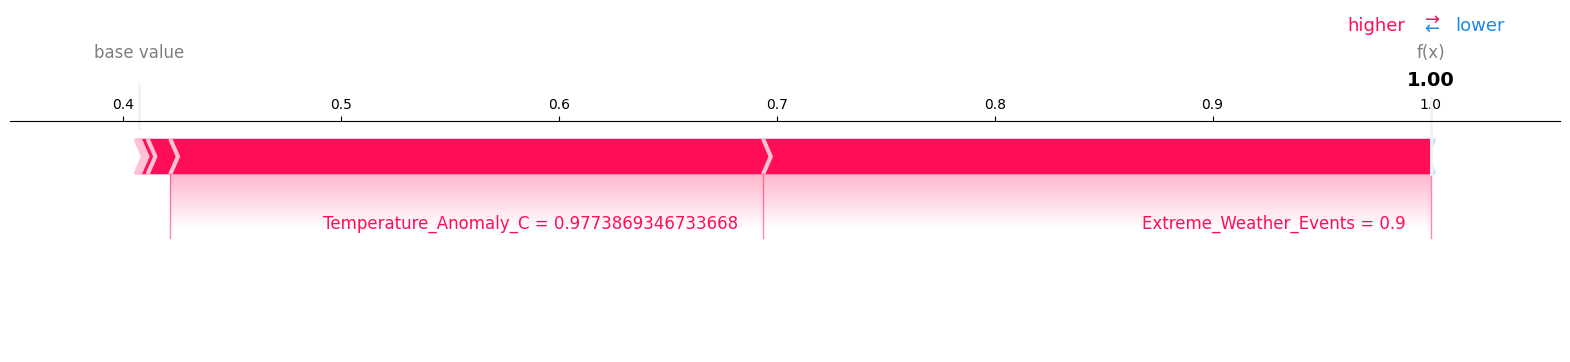

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(best_rf_model, X_train)

shap_values = explainer.shap_values(X_test)
shap_values_class1 = shap_values[:, :, 1] 

shap.summary_plot(shap_values_class1, X_test, plot_type="bar")

shap.dependence_plot("Extreme_Weather_Events", shap_values_class1, X_test, interaction_index="Temperature_Anomaly_C")

for i in [0, 1, 5, 10]:
    shap.force_plot(
        explainer.expected_value[1],
        shap_values[i, :, 1],  
        X_test.iloc[i, :],
        matplotlib=True  
    )


